# `clouddrift` : Getting started with the `binning` module

This repository contains an introduction to using the `binning` module of `clouddrift` which was written with various analyses of Lagrangian data in mind. The examples provided are using the data of the [6-hourly product](https://www.aoml.noaa.gov/phod/gdp/interpolated/data/all.php) of the [NOAA Global Drifter Program](https://www.aoml.noaa.gov/phod/gdp/index.php).

The library imports include some standard libraries (numpy, matplotlib, and cartopy) and the clouddrift imports include the main function `binned_statistics` of the `binnning` module and the `gdp6h` function of the `datasets` module.

In [7]:
# import necessary libraries
import cmocean
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# import clouddrift function and dataset 
from clouddrift.binning import binned_statistics
from clouddrift.datasets import gdp6h

#%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

The `binned_statistics` method provides a straightforward way to compute statistics over gridded bins for Lagrangian datasets, offering flexible options for selecting variables, bin sizes, ranges, and statistical functions.

In [8]:
binned_statistics?

Signature:
binned_statistics(
    coords: numpy.ndarray | list[numpy.ndarray],
    data: numpy.ndarray | list[numpy.ndarray] | None = None,
    bins: int | list = 10,
    bins_range: list | None = None,
    dim_names: list[str] | None = None,
    output_names: list[str] | None = None,
    statistics: Union[str, list, Callable[[numpy.ndarray], float]] = 'count',
) -> xarray.core.dataset.Dataset
Docstring:
Perform N-dimensional binning and compute statistics of values in each bin. The result is returned as an Xarray Dataset.

Parameters
----------
coords : array-like or list of array-like
    Array(s) of Lagrangian data coordinates to be binned. For 1D, provide a single array.
    For N-dimensions, provide a list of N arrays, each giving coordinates along one dimension.
data : array-like or list of array-like
    Data values associated with the Lagrangian coordinates in coords.
    Can be a single array or a list of arrays for multiple variables.
    Complex values are supported for the 

We are going to work with the 6-hourly NOAA GDP dataset which is lazily and remotely opened from its cloud location using the `gdp6h` function. The dataset is formatted as a [`xarray.Dataset`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) containing Lagrangian variables organized as [ragged arrays](https://clouddrift.org/#scope-and-key-features).

In [9]:
gdp6h?

Signature: gdp6h(decode_times: bool = True) -> xarray.core.dataset.Dataset
Docstring:
Returns the NOAA Global Drifter Program (GDP) 6-hourly dataset as a ragged array
Xarray dataset.

The data is accessed from zarr archive hosted on a public AWS S3 bucket accessible at
s3://noaa-oar-hourly-gdp-pds/experimental/. Original data source from NOAA's Atlantic
Oceanographic and Meteorological Laboratory (AOML) accessible at
https://www.aoml.noaa.gov/phod/gdp/index.php.

This returns the December 2024 version of the dataset including data from 1979-02-15:00:00:00Z
to 2025-01-20:00:00:00Z.

Parameters
----------
decode_times : bool, optional
    If True, decode the time coordinate into a datetime object. If False, the time
    coordinate will be an int64 or float64 array of increments since the origin
    time indicated in the units attribute. Default is True.

Returns
-------
xarray.Dataset
    6-hourly GDP dataset as a ragged array

Examples
--------
>>> from clouddrift.datasets import gdp6h


In [10]:
ds = gdp6h()
ds

<xarray.Dataset> Size: 2GB
Dimensions:                (traj: 28706, obs: 48840300)
Coordinates:
    id                     (traj) int64 230kB ...
    time                   (obs) datetime64[ns] 391MB ...
Dimensions without coordinates: traj, obs
Data variables: (12/48)
    BuoyTypeManufacturer   (traj) <U20 2MB ...
    BuoyTypeSensorArray    (traj) <U20 2MB ...
    CurrentProgram         (traj) float64 230kB ...
    DeployingCountry       (traj) <U20 2MB ...
    DeployingShip          (traj) <U20 2MB ...
    DeploymentComments     (traj) <U20 2MB ...
    ...                     ...
    start_lon              (traj) float32 115kB ...
    temp                   (obs) float32 195MB ...
    typebuoy               (traj) |S10 287kB ...
    typedeath              (traj) int8 29kB ...
    ve                     (obs) float32 195MB ...
    vn                     (obs) float32 195MB ...
Attributes: (12/18)
    Conventions:          CF-1.6
    acknowledgement:      Lumpkin, Rick; Centurioni, Luca (2019). NOAA Global...
    contributor_name:     NOAA Global Drifter Program
    contributor_role:     Data Acquisition Center
    date_created:         2025-07-14T15:15:03.441003
    doi:                  10.25921/7ntx-z961
    ...                   ...
    publisher_name:       GDP Drifter DAC
    publisher_url:        https://www.aoml.noaa.gov/phod/gdp
    summary:              Global Drifter Program six-hourly data
    time_coverage_end:    2025-01-20:00:00:00Z
    time_coverage_start:  1979-02-15:00:00:00Z
    title:                Global Drifter Program drifting buoy collection

In [11]:
#here we notice that one drifter seems to exhibit very wrong data and we remove it from the dataset in the next cell
print(np.min(ds.vn.values.flatten()[~np.isnan(ds.vn.values.flatten())]))
print(np.max(ds.vn.values.flatten()[~np.isnan(ds.vn.values.flatten())]))
min_idx = np.nanargmin(ds.vn.values)
max_idx = np.nanargmax(ds.vn.values)
print("Index of minimum vn:", min_idx)
print("Index of maximum vn:", max_idx)
from clouddrift.ragged import obs_index_to_row
n = obs_index_to_row(int(min_idx),ds.rowsize.values)
m = obs_index_to_row(int(max_idx),ds.rowsize.values)
print([m,n])
print(ds.id.values[[n,m]])


-83.85069
80.91075
Index of minimum vn: 48735210
Index of maximum vn: 48735212
[[28319], [28319]]
[[300534063907060]
 [300534063907060]]


Text(0, 0.5, 'Temperature (°C)')

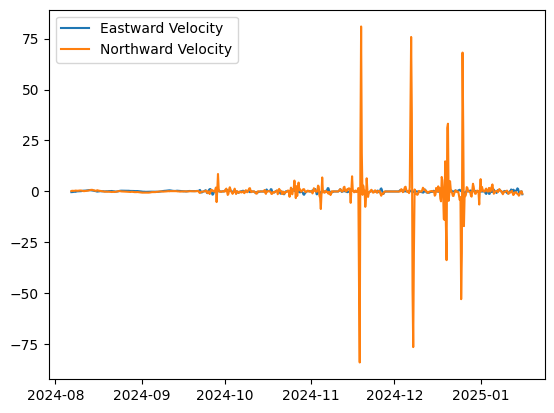

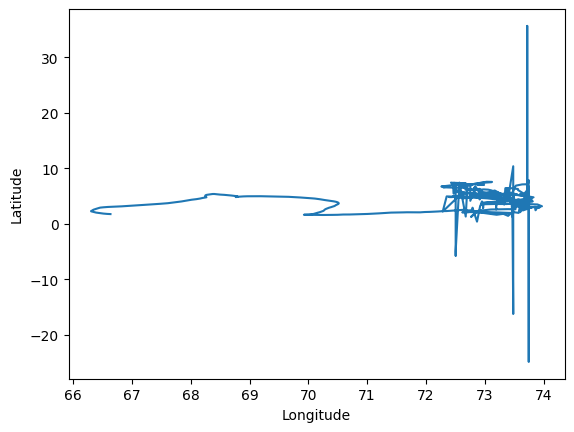

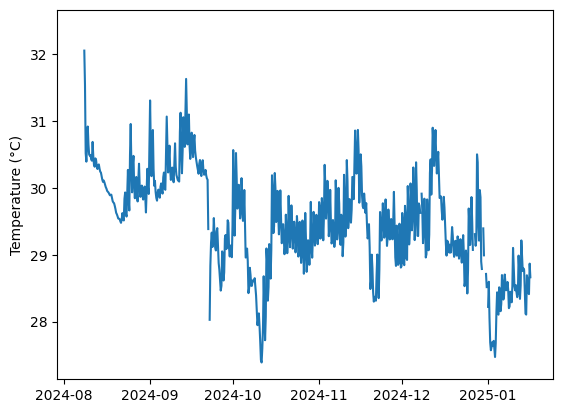

In [12]:
from clouddrift.ragged import rowsize_to_index
traj_idx = rowsize_to_index(ds["rowsize"])

#plt.figure()
#plt.plot(ds.time[traj_idx])
j = 28319
plt.figure()
plt.plot(ds.time[slice(traj_idx[j], traj_idx[j+1])], ds.ve[slice(traj_idx[j], traj_idx[j+1])],label='Eastward Velocity')
plt.plot(ds.time[slice(traj_idx[j], traj_idx[j+1])], ds.vn[slice(traj_idx[j], traj_idx[j+1])],label='Northward Velocity')
plt.legend()

plt.figure()
plt.plot(ds.lon[slice(traj_idx[j], traj_idx[j+1])],ds.lat[slice(traj_idx[j], traj_idx[j+1])])
plt.xlabel('Longitude')
plt.ylabel('Latitude')

#j = 28319
plt.figure()
plt.plot(ds.time[slice(traj_idx[j], traj_idx[j+1])], ds.temp[slice(traj_idx[j], traj_idx[j+1])])
plt.ylabel('Temperature (°C)')

In [13]:

from clouddrift.ragged import subset
# create a list of all ids but exclude 300534063907060
ids = ds.id.values.tolist()
ids = [id for id in ids if id != 300534063907060]
ds = subset(ds,{'id': ids},row_dim_name='traj')
ds

<xarray.Dataset> Size: 2GB
Dimensions:                (traj: 28705, obs: 48839648)
Coordinates:
    id                     (traj) int64 230kB 7702204 ... 300534064497800
    time                   (obs) datetime64[ns] 391MB ...
Dimensions without coordinates: traj, obs
Data variables: (12/48)
    BuoyTypeManufacturer   (traj) <U20 2MB ...
    BuoyTypeSensorArray    (traj) <U20 2MB ...
    CurrentProgram         (traj) float64 230kB ...
    DeployingCountry       (traj) <U20 2MB ...
    DeployingShip          (traj) <U20 2MB ...
    DeploymentComments     (traj) <U20 2MB ...
    ...                     ...
    start_lon              (traj) float32 115kB ...
    temp                   (obs) float32 195MB ...
    typebuoy               (traj) |S10 287kB ...
    typedeath              (traj) int8 29kB ...
    ve                     (obs) float32 195MB ...
    vn                     (obs) float32 195MB nan 0.1056 0.04974 ... 0.1604 nan
Attributes: (12/18)
    Conventions:          CF-1.6
    acknowledgement:      Lumpkin, Rick; Centurioni, Luca (2019). NOAA Global...
    contributor_name:     NOAA Global Drifter Program
    contributor_role:     Data Acquisition Center
    date_created:         2025-07-14T15:15:03.441003
    doi:                  10.25921/7ntx-z961
    ...                   ...
    publisher_name:       GDP Drifter DAC
    publisher_url:        https://www.aoml.noaa.gov/phod/gdp
    summary:              Global Drifter Program six-hourly data
    time_coverage_end:    2025-01-20:00:00:00Z
    time_coverage_start:  1979-02-15:00:00:00Z
    title:                Global Drifter Program drifting buoy collection

# Binned statistics

We now apply the `binned_statistics` function to calculate the mean, minimum, and maximum values of velocity components (`ve` and `vn`) and of sea surface temperature (SST or `temp`) of the drifter dataset. Here we explicitly set the bins for each coordinate resulting in regular 1 by 1 degree bins in both longitude and latitude. Note that since we need to actually conduct computations on the data, these are downloaded from the cloud storage and this takes a bit of time.

In [14]:
coords = [ds.lon.values, ds.lat.values]
variables = [ds.ve.values, ds.vn.values, ds.temp.values]

# Compute 3D binned averages
ds_global = binned_statistics(
    coords=coords,
    data=variables,
    bins = [np.arange(-180, 181, 1), np.arange(-90, 91, 1)],
    dim_names=("lon", "lat"),
    output_names=["ve", "vn", "temp"],
    statistics=["mean", "min", "max"],
)

ds_global

<xarray.Dataset> Size: 5MB
Dimensions:    (lon: 360, lat: 180)
Coordinates:
  * lon        (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat        (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    ve_mean    (lon, lat) float64 518kB nan nan nan nan ... -0.01697 0.04778 nan
    vn_mean    (lon, lat) float64 518kB nan nan nan nan ... 0.04865 0.1019 nan
    temp_mean  (lon, lat) float64 518kB nan nan nan nan nan ... nan nan nan nan
    ve_min     (lon, lat) float64 518kB nan nan nan nan ... -0.1072 -0.09268 nan
    vn_min     (lon, lat) float64 518kB nan nan nan nan ... 0.00016 0.05586 nan
    temp_min   (lon, lat) float64 518kB nan nan nan nan nan ... nan nan nan nan
    ve_max     (lon, lat) float64 518kB nan nan nan nan ... 0.08123 0.1882 nan
    vn_max     (lon, lat) float64 518kB nan nan nan nan ... 0.1279 0.148 nan
    temp_max   (lon, lat) float64 518kB nan nan nan nan nan ... nan nan nan nan

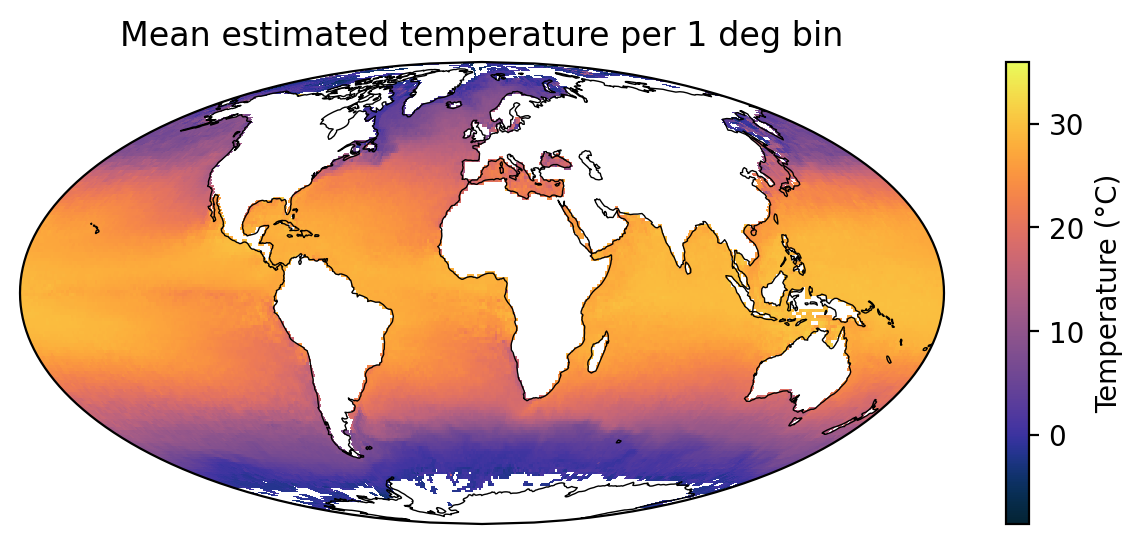

In [15]:
fig = plt.figure(figsize=(8, 3), dpi=200)
ax = fig.subplots(1, 1, subplot_kw={"projection": ccrs.Mollweide()})

pcm = ax.pcolormesh(
    ds_global.lon,
    ds_global.lat,
    ds_global["temp_mean"].values.T,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.thermal,
)
ax.set_title("Mean estimated temperature per 1 deg bin")
ax.coastlines(linewidth=0.5)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
cbar = fig.colorbar(pcm)
cbar.set_label("Temperature (°C)")

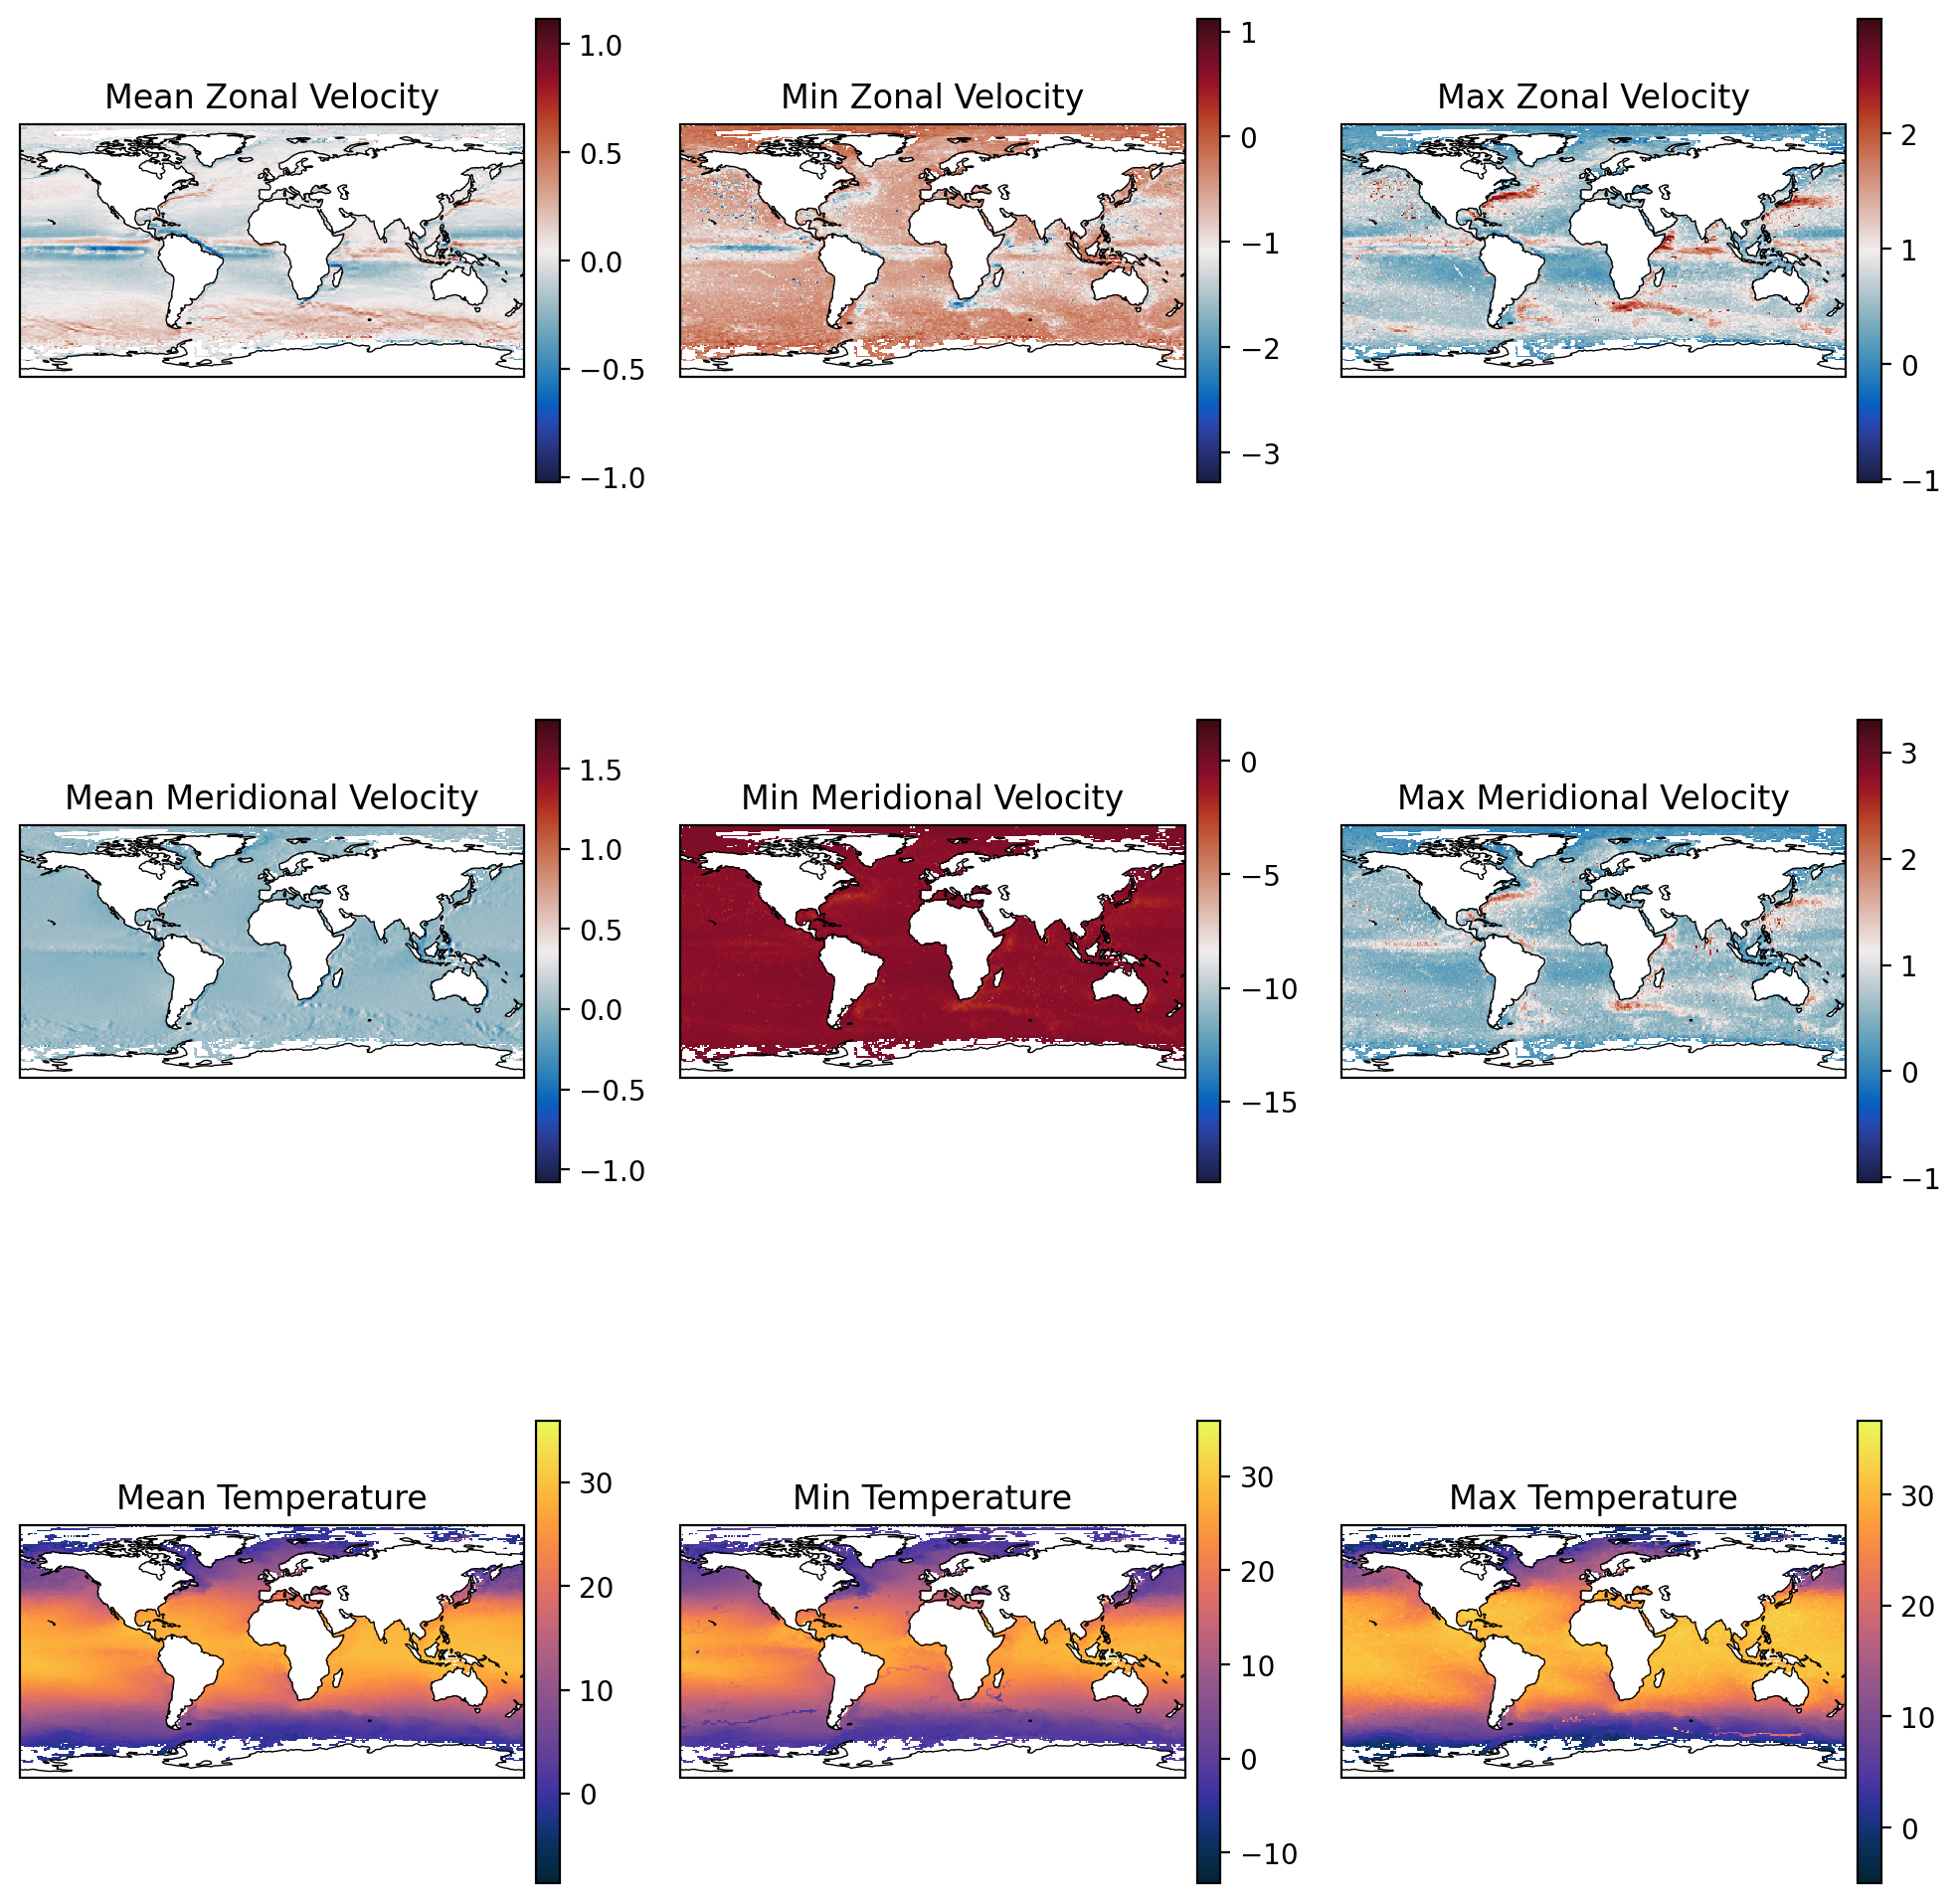

In [16]:
# now do another plot for all the stats calculated
fig, axes = plt.subplots(3, 3, figsize=(10,12), dpi=200, subplot_kw={"projection": ccrs.PlateCarree()})
stats = [
    ("ve_mean", "Mean Zonal Velocity"),
    ("ve_min", "Min Zonal Velocity"),
    ("ve_max", "Max Zonal Velocity"),
    ("vn_mean", "Mean Meridional Velocity"),
    ("vn_min", "Min Meridional Velocity"),
    ("vn_max", "Max Meridional Velocity"),
    ("temp_mean", "Mean Temperature"),
    ("temp_min", "Min Temperature"),
    ("temp_max", "Max Temperature"),
]
cmaps = [
    cmocean.cm.balance, cmocean.cm.balance, cmocean.cm.balance,
    cmocean.cm.balance, cmocean.cm.balance, cmocean.cm.balance,
    cmocean.cm.thermal, cmocean.cm.thermal, cmocean.cm.thermal,
]

climits = [(-1,1), (-1,1), (-1,1), (-1,1), (-1,1), (-1,1), (-2,50), (-2,50), (-2,50)]

for ax, (stat, title), cmap, clim in zip(axes.flat, stats, cmaps, climits):
    pcm = ax.pcolormesh(
        ds_global.lon,
        ds_global.lat,
        ds_global[stat].values.T,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
    )
    ax.set_title(title)
    ax.coastlines(linewidth=0.5)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    # Make colorbar the same height as the subplot
    cbar = fig.colorbar(pcm, ax=ax, orientation="vertical", pad=0.02, shrink=.5)
    #pcm.set_clim(*clim)

plt.tight_layout()

# Gulf of Mexico

Let's visualize for example, the maximum velocity recorded by the Global Drifter Program inside 0.25º bins in the Gulf of Mexico. For this, we can subset our dataset using `clouddrift.ragged.subset`, see [the clouddrift documentation for more details](https://clouddrift.org/_autosummary/clouddrift.ragged.subset.html#clouddrift.ragged.subset) to select the drifters in that region. Alternatively, we can simply specify the region of interest by specifing the `bins_range` directly into `binned_statistics`.

In [17]:
# Compute 3D binned averages
ds_binned = binned_statistics(
    coords=coords,
    data=variables,
    bins=[80, 52],
    bins_range=[[-98, -78], [18, 31]],
    dim_names=("lon", "lat"),
    output_names=["ve", "vn", "temp"],
    statistics=["max"],
)

ds_binned

<xarray.Dataset> Size: 101kB
Dimensions:   (lon: 80, lat: 52)
Coordinates:
  * lon       (lon) float64 640B -97.88 -97.62 -97.38 ... -78.62 -78.38 -78.12
  * lat       (lat) float64 416B 18.12 18.38 18.62 18.88 ... 30.38 30.62 30.88
Data variables:
    ve_max    (lon, lat) float64 33kB nan nan nan nan ... 0.7086 0.5948 0.8804
    vn_max    (lon, lat) float64 33kB nan nan nan nan ... 0.7867 0.5692 0.5039
    temp_max  (lon, lat) float64 33kB nan nan nan nan ... 30.19 29.58 29.97

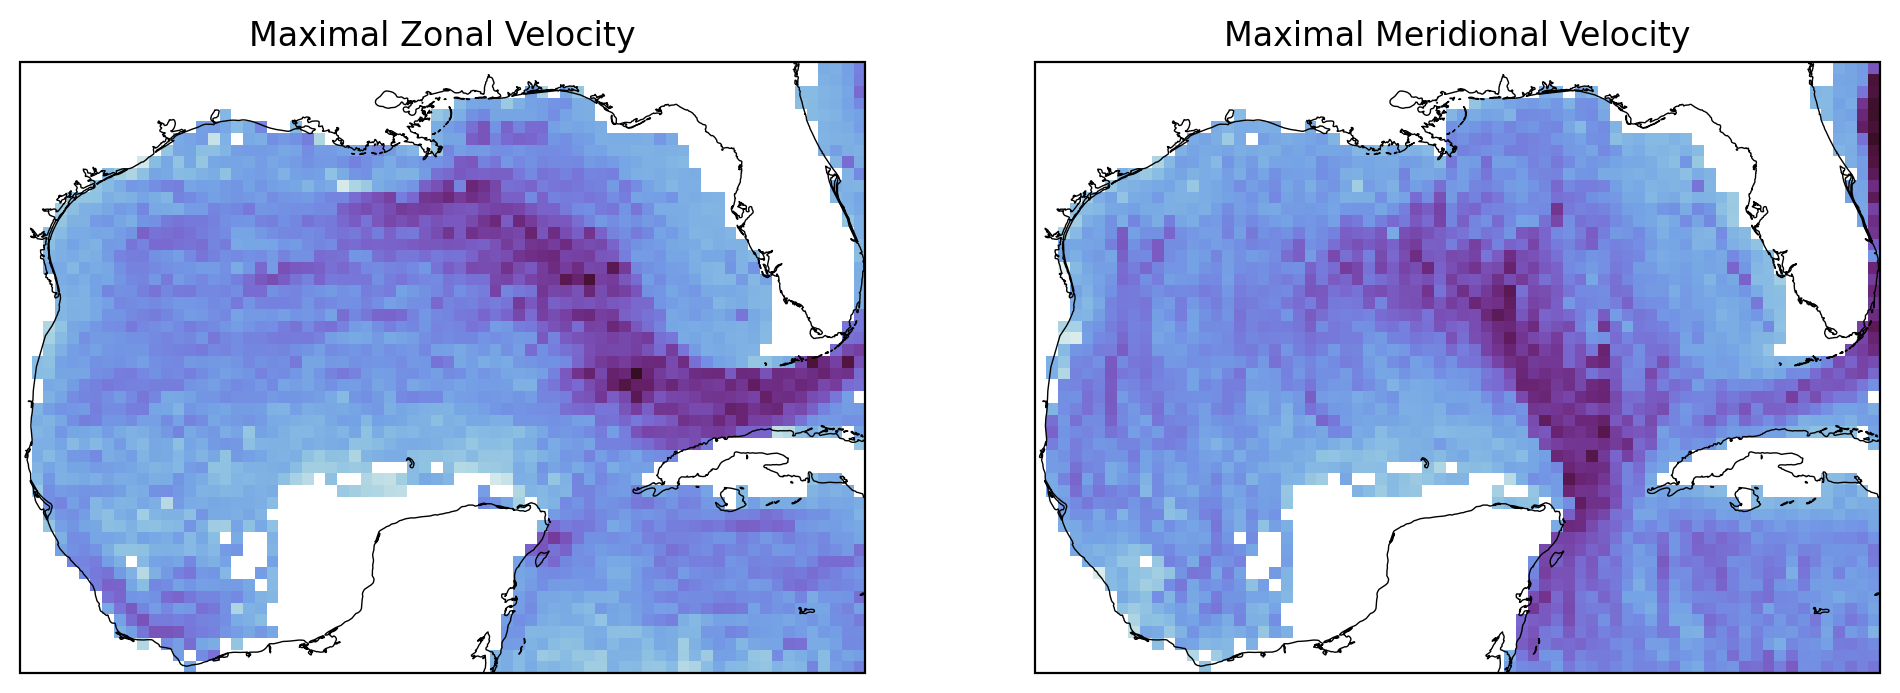

In [18]:
fig = plt.figure(figsize=(12, 6), dpi=200)
axes = fig.subplots(1, 2, subplot_kw={"projection": ccrs.PlateCarree()})

axes[0].pcolormesh(
    ds_binned.lon,
    ds_binned.lat,
    ds_binned["ve_max"].values.T,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.dense,
)

axes[1].pcolormesh(
    ds_binned.lon,
    ds_binned.lat,
    ds_binned["vn_max"].values.T,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.dense,
)

titles = ["Maximal Zonal Velocity", "Maximal Meridional Velocity"]
for i, ax in enumerate(axes):
    ax.set_title(titles[i])
    ax.coastlines(linewidth=0.5)
    ax.set_extent([-98, -80, 18, 31], crs=ccrs.PlateCarree())
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")


Standard statistics passed to `binned_statistics` can be specified as strings. The supported values are `count`, `sum`, `mean`, `median`, `std`, `min`, `max`, with the default being `count`. Let's try them all for this region:

In [19]:
ds_binned_all = binned_statistics(
    coords=coords,
    data=variables,
    bins=[80, 52],
    bins_range=[[-98, -78], [18, 31]],
    dim_names=("lon", "lat"),
    output_names=["ve", "vn", "temp"],
    statistics=["count", "sum", "mean", "median", "std", "min", "max"],
)

ds_binned_all

<xarray.Dataset> Size: 700kB
Dimensions:      (lon: 80, lat: 52)
Coordinates:
  * lon          (lon) float64 640B -97.88 -97.62 -97.38 ... -78.38 -78.12
  * lat          (lat) float64 416B 18.12 18.38 18.62 ... 30.38 30.62 30.88
Data variables: (12/21)
    ve_count     (lon, lat) int64 33kB 0 0 0 0 0 0 0 ... 388 409 341 391 252 195
    vn_count     (lon, lat) int64 33kB 0 0 0 0 0 0 0 ... 388 409 341 391 252 195
    temp_count   (lon, lat) int64 33kB 0 0 0 0 0 0 0 ... 383 400 337 370 240 190
    ve_sum       (lon, lat) float64 33kB 0.0 0.0 0.0 ... -26.49 -27.17 -13.83
    vn_sum       (lon, lat) float64 33kB 0.0 0.0 0.0 ... -40.27 -33.11 -23.59
    temp_sum     (lon, lat) float64 33kB 0.0 0.0 0.0 ... 6.126e+03 4.921e+03
    ...           ...
    ve_min       (lon, lat) float64 33kB nan nan nan ... -0.9299 -1.091 -1.037
    vn_min       (lon, lat) float64 33kB nan nan nan ... -0.9903 -0.9248 -1.298
    temp_min     (lon, lat) float64 33kB nan nan nan nan ... 21.2 21.31 21.48
    ve_max       (lon, lat) float64 33kB nan nan nan ... 0.7086 0.5948 0.8804
    vn_max       (lon, lat) float64 33kB nan nan nan ... 0.7867 0.5692 0.5039
    temp_max     (lon, lat) float64 33kB nan nan nan nan ... 30.19 29.58 29.97

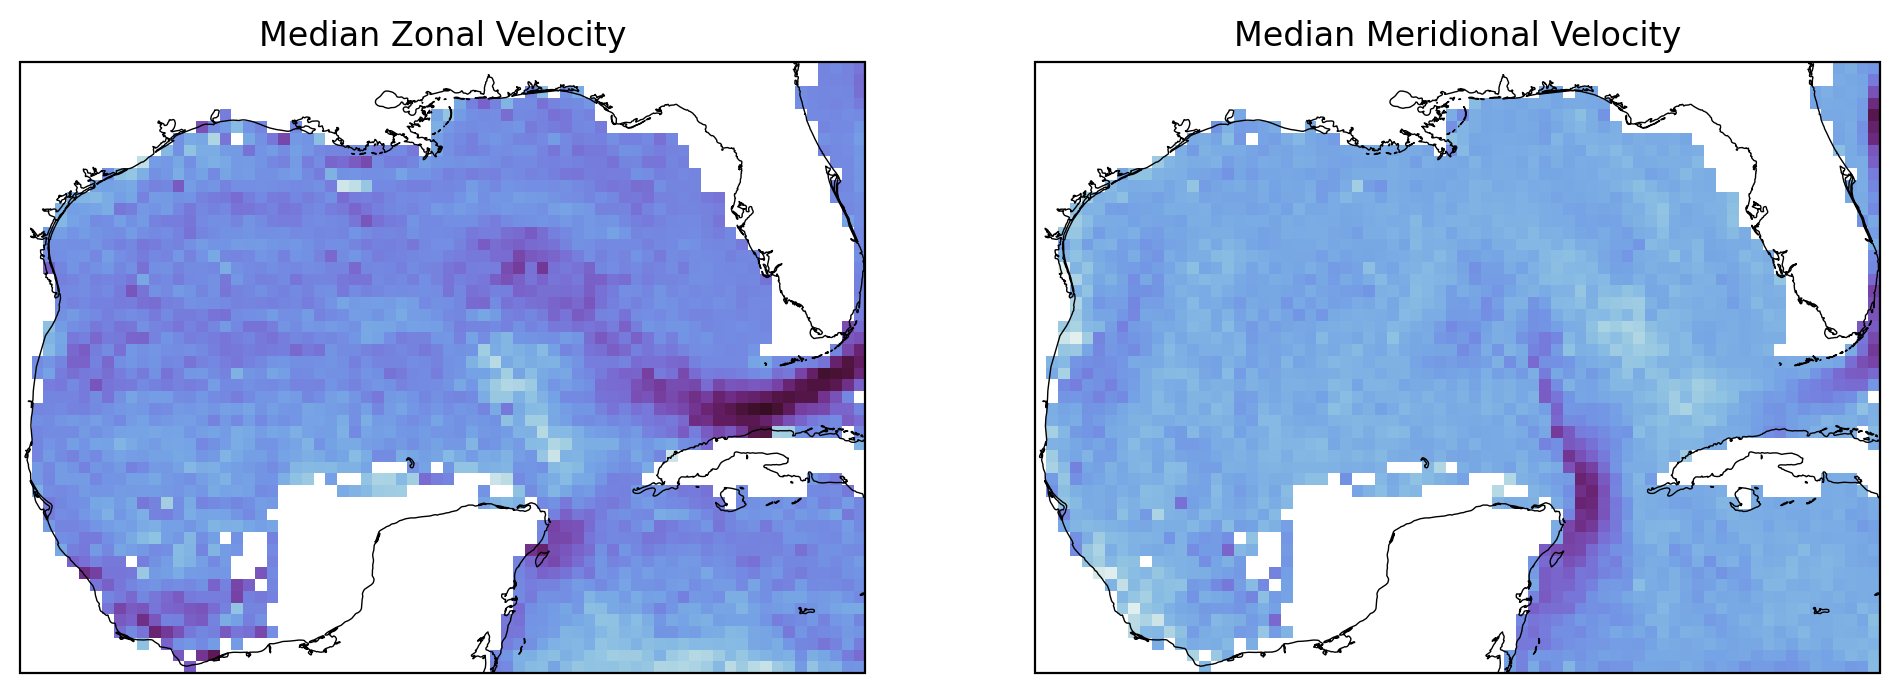

In [20]:
# let's plot the median velocity components:
fig = plt.figure(figsize=(12, 6), dpi=200)
axes = fig.subplots(1, 2, subplot_kw={"projection": ccrs.PlateCarree()})

axes[0].pcolormesh(
    ds_binned_all.lon,
    ds_binned_all.lat,
    ds_binned_all["ve_median"].values.T,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.dense,
)

axes[1].pcolormesh(
    ds_binned_all.lon,
    ds_binned_all.lat,
    ds_binned_all["vn_median"].values.T,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.dense,
)

titles = ["Median Zonal Velocity", "Median Meridional Velocity"]
for i, ax in enumerate(axes):
    ax.set_title(titles[i])
    ax.coastlines(linewidth=0.5)
    ax.set_extent([-98, -80, 18, 31], crs=ccrs.PlateCarree())
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

## Using a function to calculate another statistics

`binned_statistics` also accepts a custom function as a callable for univariate statistical functions that take a 1D array of values and return a single value (`Callable[[np.ndarray], float]`. The callable is applied to each variable of data. For example, you can use `np.var` to obtain the variance of each variable per bin.

In [21]:
ds_binned_callable = binned_statistics(
    coords=coords,
    data=variables,
    bins=[80, 52],
    bins_range=[[-98, -78], [18, 31]],
    dim_names=("lon", "lat"),
    output_names=["ve", "vn", "temp"],
    statistics=[
        np.var,
    ],
)

ds_binned_callable

<xarray.Dataset> Size: 101kB
Dimensions:   (lon: 80, lat: 52)
Coordinates:
  * lon       (lon) float64 640B -97.88 -97.62 -97.38 ... -78.62 -78.38 -78.12
  * lat       (lat) float64 416B 18.12 18.38 18.62 18.88 ... 30.38 30.62 30.88
Data variables:
    ve_var    (lon, lat) float64 33kB nan nan nan nan ... 0.06194 0.06918 0.0795
    vn_var    (lon, lat) float64 33kB nan nan nan ... 0.05846 0.06922 0.07022
    temp_var  (lon, lat) float64 33kB nan nan nan nan ... 6.589 6.413 5.082

For functions that require setting an extra parameter (such as `np.percentile(a, q)`), you can use `partial` as follows:

In [22]:
from functools import partial

ds_binned_partial = binned_statistics(
    coords=coords,
    data=variables,
    bins=[80, 52],
    bins_range=[[-98, -78], [18, 31]],
    dim_names=("lon", "lat"),
    output_names=["ve", "vn", "temp"],
    statistics=[
        "mean",
        partial(np.percentile, q=25),
        partial(np.percentile, q=50),
        partial(np.percentile, q=75),
    ],
)

ds_binned_partial


<xarray.Dataset> Size: 400kB
Dimensions:            (lon: 80, lat: 52)
Coordinates:
  * lon                (lon) float64 640B -97.88 -97.62 -97.38 ... -78.38 -78.12
  * lat                (lat) float64 416B 18.12 18.38 18.62 ... 30.62 30.88
Data variables:
    ve_mean            (lon, lat) float64 33kB nan nan nan ... -0.1078 -0.07093
    vn_mean            (lon, lat) float64 33kB nan nan nan ... -0.1314 -0.121
    temp_mean          (lon, lat) float64 33kB nan nan nan ... 24.83 25.52 25.9
    ve_percentile      (lon, lat) float64 33kB nan nan nan ... -0.2681 -0.2128
    vn_percentile      (lon, lat) float64 33kB nan nan nan ... -0.3028 -0.2836
    temp_percentile    (lon, lat) float64 33kB nan nan nan ... 22.52 23.4 23.92
    ve_percentile_0    (lon, lat) float64 33kB nan nan nan ... -0.08546 -0.1021
    vn_percentile_0    (lon, lat) float64 33kB nan nan nan ... -0.1094 -0.08837
    temp_percentile_0  (lon, lat) float64 33kB nan nan nan ... 23.92 25.68 26.52
    ve_percentile_1    (lon, lat) float64 33kB nan nan nan ... 0.06253 0.07333
    vn_percentile_1    (lon, lat) float64 33kB nan nan nan ... 0.02219 0.05841
    temp_percentile_1  (lon, lat) float64 33kB nan nan nan ... 27.42 27.92 27.67

Alternatively, one can create a new functions to wrap the `np.percentile` call. Note that in this situation, the variable names are set using our custom function names `percentile_25`, `percentile_50`, `percentile_75`, and not `percentile` as in the previous example (the suffixes `_0` and `_1` were automatically added to avoid duplicate variable names).

In [23]:
def percentile_25(x):
    return np.percentile(x, q=25)


def percentile_50(x):
    return np.percentile(x, q=75)


def percentile_75(x):
    return np.percentile(x, q=75)


ds_binned_func = binned_statistics(
    coords=coords,
    data=variables,
    bins=[80, 52],
    bins_range=[[-98, -78], [18, 31]],
    dim_names=("lon", "lat"),
    output_names=["ve", "vn", "temp"],
    statistics=["mean", percentile_25, percentile_50, percentile_75],
)

ds_binned_func

<xarray.Dataset> Size: 400kB
Dimensions:             (lon: 80, lat: 52)
Coordinates:
  * lon                 (lon) float64 640B -97.88 -97.62 ... -78.38 -78.12
  * lat                 (lat) float64 416B 18.12 18.38 18.62 ... 30.62 30.88
Data variables:
    ve_mean             (lon, lat) float64 33kB nan nan nan ... -0.1078 -0.07093
    vn_mean             (lon, lat) float64 33kB nan nan nan ... -0.1314 -0.121
    temp_mean           (lon, lat) float64 33kB nan nan nan ... 24.83 25.52 25.9
    ve_percentile_25    (lon, lat) float64 33kB nan nan nan ... -0.2681 -0.2128
    vn_percentile_25    (lon, lat) float64 33kB nan nan nan ... -0.3028 -0.2836
    temp_percentile_25  (lon, lat) float64 33kB nan nan nan ... 22.52 23.4 23.92
    ve_percentile_50    (lon, lat) float64 33kB nan nan nan ... 0.06253 0.07333
    vn_percentile_50    (lon, lat) float64 33kB nan nan nan ... 0.02219 0.05841
    temp_percentile_50  (lon, lat) float64 33kB nan nan nan ... 27.92 27.67
    ve_percentile_75    (lon, lat) float64 33kB nan nan nan ... 0.06253 0.07333
    vn_percentile_75    (lon, lat) float64 33kB nan nan nan ... 0.02219 0.05841
    temp_percentile_75  (lon, lat) float64 33kB nan nan nan ... 27.92 27.67

# Multi-variables statistics

Finally, the custom function to apply in each bin can also be defined by a tuple of `(output_name, callable)`, such as for multivariate statistics. `output_name` is used to identify the resulting variable. In this case, the callable will receive the data arrays provided in `data` as a list which can be referenced in the custom function. For example, to calculate ocean kinetic energy, you can pass `data = [u, v]` and  `statistics=("ke", lambda data: np.sqrt(np.mean(data[0] ** 2 + data[1] ** 2)))`.

In [24]:
ds_binned_ke = binned_statistics(
    coords=coords,
    data=variables,
    bins=[80, 52],
    bins_range=[[-98, -78], [18, 31]],
    dim_names=("lon", "lat"),
    output_names=["ve", "vn", "temp"],
    statistics=("ke", lambda data: np.nanmean(data[0] ** 2 + data[1] ** 2)),
)

ds_binned_ke

/var/folders/fx/qsnv05_94vs9qzp4p0qww8c00000gn/T/ipykernel_32234/2099408857.py:8: RuntimeWarning: Mean of empty slice
  statistics=("ke", lambda data: np.nanmean(data[0] ** 2 + data[1] ** 2)),


<xarray.Dataset> Size: 34kB
Dimensions:  (lon: 80, lat: 52)
Coordinates:
  * lon      (lon) float64 640B -97.88 -97.62 -97.38 ... -78.62 -78.38 -78.12
  * lat      (lat) float64 416B 18.12 18.38 18.62 18.88 ... 30.38 30.62 30.88
Data variables:
    ke       (lon, lat) float64 33kB nan nan nan nan ... 0.1356 0.1673 0.1694

Text(0, 0.5, 'Latitude')

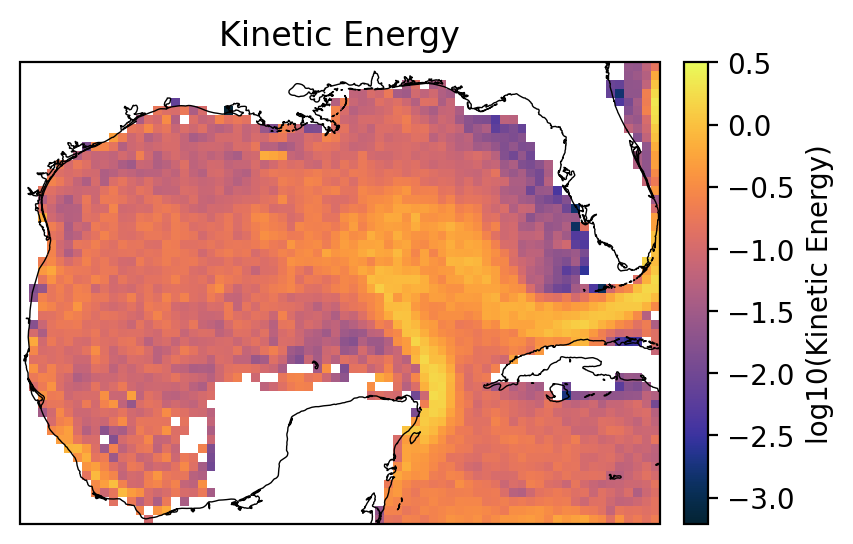

In [29]:
# plotting the result
fig, ax = plt.subplots(1, 1, figsize=(8,3), dpi=200, subplot_kw={"projection": ccrs.PlateCarree()})

#fig = plt.figure(figsize=(8, 3), dpi=200)
#ax = fig.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})

pcm = ax.pcolormesh(
    ds_binned_ke.lon,
    ds_binned_ke.lat,
    np.log10(ds_binned_ke["ke"].values.T),
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.thermal,
)
# no idea why the colorbar is not added to the right figure/plot???
cbar = fig.colorbar(pcm, ax=ax, orientation="vertical", pad=0.02)
cbar.set_label("log10(Kinetic Energy)")

ax.set_title("Kinetic Energy")
ax.coastlines(linewidth=0.5)
ax.set_extent([-98, -80, 18, 31], crs=ccrs.PlateCarree())
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

